In [1]:
%matplotlib inline
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn_extra.cluster import KMedoids
import seaborn as sns; sns.set() 
from matplotlib.ticker import PercentFormatter
import random

## Visualiser les datas

In [2]:
#fonction pour extraire les données x, y, p, Az, Al d'une ligne d'un fichier, données converties en float

def extraire_datas_line(line):
    x = ""
    y = ""
    p = ""
    az = ""
    al = ""
    
    i = 0
    while line[i] != " ":
        x += line[i]
        i += 1
    i += 1
    while line[i] != " ":
        y += line[i]
        i += 1
    i += 1
    while line[i] != " ":
        p += line[i]
        i += 1
    i += 1
    while line[i] != " ":
        az += line[i]
        i += 1
    i += 1
    while i < len(line) and line[i] != " ":
        al += line[i]
        i += 1
    return float(x), float(y), float(p), float(az), float(al)

#utilise la fonction précédente
#extrait d'un fichier un tableau des X, de même pour Y, P, Az et Al
def extraire_datas(n_file):
    path = "./Données/Base de données/" + n_file + ".txt"
    file = open(path, "r")
    X = []
    Y = []
    P = []
    Az = []
    Al = []
    for line in file:
        x, y, p, az, al = extraire_datas_line(line)
        X.append(x)
        Y.append(y)
        P.append(p)
        Az.append(az)
        Al.append(al)
    file.close()
    return X, Y, P, Az, Al
    
    
#fonction pour tracer la trajectoire Y en fonction de X d'un fichier
#trace en pointillés les endroits où la pression est nulle
#boolean = True -> ne pas afficher, rien -> afficher
def tracer_X_Y(n_file, *args):
    X, Y, P, Az, Al = extraire_datas(n_file)
    X_pression, Y_pression = [], []
    X_sans_pression, Y_sans_pression = [], []
    for i in range(len(X)):
        if P[i] == 0:
            X_sans_pression.append(X[i])
            Y_sans_pression.append(Y[i])
        else:
            X_pression.append(X[i])
            Y_pression.append(Y[i])

    if len(args) == 0:
        plt.plot(X_pression, Y_pression, c = 'r', alpha = 0.8, label='Pression non nulle')
        plt.plot(X_sans_pression, Y_sans_pression, '--', c = 'blue', alpha = 0.6, label = 'Pression nulle')
        plt.title('Personne n°' + str(int(n_file[0])+1) + ", signature n°"+ str(int(n_file[2])+1))
        plt.xticks([])
        plt.yticks([])
        plt.legend(loc='best')
        plt.show()
    else:
        return X_pression, Y_pression, X_sans_pression, Y_sans_pression

#fonction pour afficher toutes les signatures d'une personne
#mettre le numéro de la personne en paramètre, on commence les numéros des personnes à partir de 1
def tracer_signatures_personne(n_personne):
    n_file = str(n_personne-1) + "v"
    for i in range(8):
        fig, axs = plt.subplots(1, 3, figsize=(15, 4))
        for j in range(3):
            file = n_file + str(3*i+j)
            Xp, Yp, Xsp, Ysp = tracer_X_Y(file, False)
            axs[j].plot(Xp, Yp, c='r', alpha=0.8)
            axs[j].plot(Xsp, Ysp, '--', c='blue', alpha=0.6)
            axs[j].set_title("Signature n°" + str(3*i+j+1))
            axs[j].set_xticks([])
            axs[j].set_yticks([])

    fig, axs = plt.subplots(1, 1, figsize=(5, 4))
    Xp, Yp, Xsp, Ysp = tracer_X_Y(n_file + "24", False)
    axs.plot(Xp, Yp, c='r', alpha=0.8)
    axs.plot(Xsp, Ysp, '--', c='r', alpha=0.6)
    axs.set_title("Signature n°" + str(25))

    plt.show()

## 1st part :  Unsupervised classification of individuals to analyze the contribution of the complexity measure

In [3]:
def extraire_complexite(n_personne, n_complexite):
    path = "./Données/Complexité avec " + str(n_complexite) + "G (100x25).txt"
    file = open(path, "r")
    complexites = []
    lines = file.readlines()
    line = lines[n_personne - 1]
    pointeur = 0
    n_complexites = 0
    while n_complexites != 25:
        new_complexite = ""
        while pointeur < len(line) and line[pointeur] != '\t':
            if line[pointeur] == ",": #on remplace les virgules par des points pour respecter la notation americaine
                new_complexite += "."
            else:
                new_complexite += line[pointeur]
            pointeur += 1
        pointeur += 1 # on saute apres la tabulation
        complexites.append(float(new_complexite)) # on convertit en float
        n_complexites += 1
    
    file.close()
    return complexites
        

def complexite_moyenne(n_personne, n_complexite):
    complexites = extraire_complexite(n_personne, n_complexite)
    return np.sum(complexites)/len(complexites)

In [4]:
complexites_moyennes_4G = [complexite_moyenne(k, 4) for k in range(1, 101)]
complexites_moyennes_8G = [complexite_moyenne(k, 8) for k in range(1, 101)]
complexites_moyennes_24G = [complexite_moyenne(k, 24) for k in range(1, 101)]

X_4_original = np.reshape(complexites_moyennes_4G, (-1, 1))
X_8_original = np.reshape(complexites_moyennes_8G, (-1, 1))
X_24_original = np.reshape(complexites_moyennes_24G, (-1, 1))

X_4 = np.reshape(complexites_moyennes_4G, (-1, 1)) / np.max(complexites_moyennes_4G)
X_8 = np.reshape(complexites_moyennes_8G, (-1, 1)) / np.max(complexites_moyennes_8G)
X_24 = np.reshape(complexites_moyennes_24G, (-1, 1)) / np.max(complexites_moyennes_24G)

## Définition de fonctions utiles

In [5]:
def complexite_cluster(k):
    if k==0:
        return "complexité faible"
    if k==1:
        return "complexité moyenne"
    return "complexité forte"

In [6]:
def image_plus_proche_moyenne_entropie(n_personne, n_complexite, moyenne):
    complexites = extraire_complexite(n_personne, n_complexite)
    distance_min = (complexites[0] - moyenne)**2
    indice_dist_min = 0
    for i in range(1, len(complexites)):
        if (complexites[i] - moyenne)**2 < distance_min:
            distance_min = (complexites[i] - moyenne)**2
            indice_dist_min = i
    return i

In [7]:
def visualiser_representants(X, representants_clusters, n_complexite):
    n = len(representants_clusters)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for j in range(n):
        n_personne = int(representants_clusters[j])
        n_image = image_plus_proche_moyenne_entropie(n_personne, n_complexite, X[n_personne])
        file = str(n_personne) + "v" + str(n_image)
        Xp, Yp, Xsp, Ysp = tracer_X_Y(file, False)
        axs[j].plot(Xp, Yp, c='r', alpha=0.8)
        axs[j].plot(Xsp, Ysp, '--', c='blue', alpha=0.6)
        axs[j].set_title('Représentant cluster: ' + complexite_cluster(j) + "\n")
        axs[j].set_xticks([])
        axs[j].set_yticks([])
    plt.show()

In [8]:
def correspondance_representants_moyenne_cluster(X, clusters, representants_cl):
    moy_cl_faible = np.sum(X[clusters[0]])/len(clusters[0])
    moy_cl_moyen = np.sum(X[clusters[1]])/len(clusters[1])
    moy_cl_fort = np.sum(X[clusters[2]])/len(clusters[2])
    
    valeur_c0 = X[int(representants_cl[0])][0]
    valeur_c1 = X[int(representants_cl[1])][0]
    valeur_c2 = X[int(representants_cl[2])][0]
    
    print("Moyenne du cluster de complexité faible =", round(moy_cl_faible, 2))
    print("Valeur du représentant du cluster de complexité faible =", round(valeur_c0, 2))
    print("Distance =", round(abs(moy_cl_faible - valeur_c0), 2), "\n")

    print("Moyenne du cluster de complexité moyenne =", round(moy_cl_moyen, 2))
    print("Valeur du représentant du cluster de complexité moyenne =", round(valeur_c1, 2))
    print("Distance =", round(abs(moy_cl_moyen - valeur_c1), 2), "\n")
    
    print("Moyenne du cluster de complexité fort =", round(moy_cl_fort, 2))
    print("Valeur du représentant du cluster de complexité forte =", round(valeur_c2, 2))
    print("Distance =", round(abs(moy_cl_fort - valeur_c2), 2), "\n")

L'inertie intra-classe se calcule par la formule suivante : 
$$
\text{Inertie intra-classe = } \sum_{k=1}^3 \sum_{x_i \in A_k} ||x - c_k||^2
$$
$\newline \text{où les } A_k \text{ sont les clusters, et les } c_k \text{ sont leurs centres}$
$\newline$
L'inertie inter-classe se calcule par la formule suivante :
$$
\text{Inertie inter-classe = } \sum_{k=1}^3 \overline{A_k} ||g - c_k||^2
$$
$\text{où les } \overline{A_k} \text{sont les cardinalités de clusters, et g est le centre de gravité de l'ensemble du dataset}$

In [9]:
def inertie_intra_classe(X, centroides):
    centroides_int = []
    for i in range(len(centroides)):
        centroides_int.append(int(centroides[i]))
        
    inertie_tot = 0
    for x in X:
        inertie_tot += min((x-X[centroides_int[0]])**2, (x-X[centroides_int[1]])**2, (x-X[centroides_int[2]])**2)
    return inertie_tot

def inertie_inter_classe(X, clusters, centroides):
    centroides_int = []
    for i in range(len(centroides)):
        centroides_int.append(int(centroides[i]))
        
    g = np.sum(X)/len(X) #centre de gravite de toutes les donnees            
    inertie_inter = 0
    for i in range(len(centroides)):
        inertie_inter += len(clusters[i]) * (g - X[centroides_int[i]])**2
    return inertie_inter

In [10]:
def classer_clusters_par_complexite(X, clusters):
    moyenne_clusters = [np.sum(X[clusters[i]]) / len(clusters[i]) for i in range(len(clusters))]
    max_moyennes = np.max(moyenne_clusters)
    
    sorted_clusters = []
    while len(sorted_clusters) != len(clusters):
        minimum = moyenne_clusters.index(min(moyenne_clusters))
        sorted_clusters.append(clusters[minimum])
        moyenne_clusters[minimum] = max_moyennes + 1
    
    return sorted_clusters

In [11]:
def classer_representants_par_complexite(X, representants_cl):
    valeurs_representants = [X[int(representants_cl[i])] for i in range(len(representants_cl))]
    max_valeurs = np.max(valeurs_representants)
    
    sorted_representants = []
    while len(sorted_representants) != len(representants_cl):
        minimum = valeurs_representants.index(min(valeurs_representants))
        sorted_representants.append(representants_cl[minimum])
        valeurs_representants[minimum] = max_valeurs + 1
        
    return sorted_representants

### Première tentative : méthode DBSCAN

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

On doit d'abord chercher la taille du rayon epsilon pour appliquer notre DBSCAN.
On s'inspire de ce papier pour trouver cette valeur : https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf.
L'idée est la suivante : on calcule pour chaque point la distance aux n points les plus proches du dataset, puis on trie
et affiche ces valeurs. On regarde alors pour quelle valeur d'epsilon un fort angle apparait (un peu à la manière de la
méthode du coude pour K-Means). On sélectionne alors cette valeur comme notre epsilon optimal.

In [13]:
# on choisit de calculer la distance de chaque point à ses  n=3 points les plus proches

def trouver_epsilon(n_complexite):
    if n_complexite == 4:
        X = X_4
    elif n_complexite == 8:
        X = X_8
    else:
        X = X_24
    
    neigh = NearestNeighbors(n_neighbors=3)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.ylabel('Valeurs d\'epsilon')
    plt.xlabel('Distances')
    plt.title('Graphe pour chercher epsilon optimal - ' + str(n_complexite) + "G")
    plt.show()

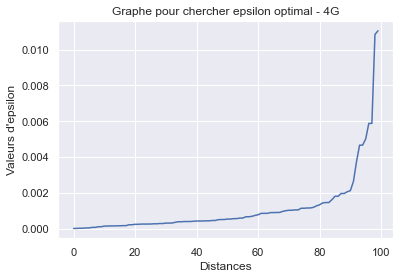

In [14]:
trouver_epsilon(4) # pour 4G, on choisit epsilon = 0.002
eps_4 = 0.002

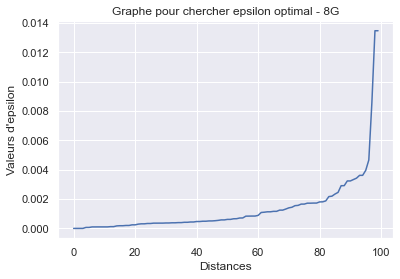

In [15]:
trouver_epsilon(8) # pour 8G, on choisit epsilon = 0.004
eps_8 = 0.004

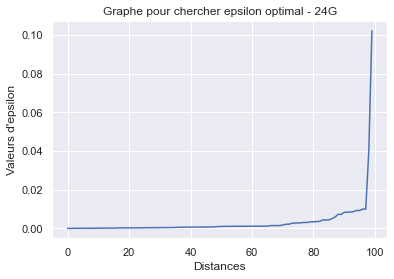

In [16]:
trouver_epsilon(24) # pour 24G, on choisit epsilon = 0.01
eps_24 = 0.01

In [19]:
def modele_dbscan(n_complexite, *args):
    if n_complexite == 4:
        X = X_4
        X_original = X_4_original
        epsilon = eps_4
    elif n_complexite == 8:
        X = X_8
        X_original = X_8_original
        epsilon = eps_8
    else:
        X = X_24
        X_original = X_24_original
        epsilon = eps_24
    
    model = DBSCAN(eps=epsilon, min_samples=3).fit(X)
    model.fit(X)
    
    nb_clusters = np.unique(model.labels_)
    clusters_dbscan = []
    for k in nb_clusters:
        cluster_k = [i for i in range(100) if model.labels_[i] == k]
        clusters_dbscan.append(cluster_k)
    
    print()
    print("Méthode DBSCAN - Complexités " + str(n_complexite)+"G\n")
    print("Nombre de clusters déterminés : " + str(len(clusters_dbscan)) + "\n")
    for cluster_k in clusters_dbscan:
        print("Pourcentage cluster", model.labels_[cluster_k[0]], ":", len(cluster_k), "%")
        
    #afficher les données en points pour montrer les clusters
    colors = ['r', 'blue', 'green', 'c', 'm', 'orange', 'yellow', 'olivedrab', 'indigo', 'violet', 'pink', 'slategray', 
                'aqua', 'k', 'chocolate', 'lightcoral']
    nb_colors = 0
    for k in range(len(clusters_dbscan)):
        plt.scatter(clusters_dbscan[k], X[clusters_dbscan[k]], color = colors[nb_colors], s=10, cmap='viridis', 
                    label = "Cluster " + str(model.labels_[clusters_dbscan[k][0]]))
        nb_colors += 1
    
    #plt.legend(loc = 'best')
    plt.title('Répartition des points en clusters, ' + str(n_complexite) + "G")
    plt.xlabel('Personnes')
    plt.ylabel('Valeur de complexité moyenne')
    plt.show()
        
    nb_colors = 0
    for k in range(len(clusters_dbscan)):
        plt.scatter(clusters_dbscan[k], X[clusters_dbscan[k]], color = colors[nb_colors], s=10, cmap='viridis', 
                label = "Cluster " + str(model.labels_[clusters_dbscan[k][0]]))
        nb_colors += 1
    
    #plt.legend(loc = 'best')
    plt.ylim(0.3, 1.05) #fixer l'echelle des y
    plt.title('Répartition des points en clusters, ' + str(n_complexite) + "G, graphe à l'échelle")
    plt.xlabel('Personnes')
    plt.ylabel('Valeur de complexité moyenne')
    plt.show()
        
    nb_colors = 0
    for k in range(len(clusters_dbscan)):
        plt.scatter(len(clusters_dbscan[k])*[k], X[clusters_dbscan[k]], color = colors[nb_colors], s=10, cmap='viridis', 
                label = "Cluster " + str(model.labels_[clusters_dbscan[k][0]]))
        nb_colors += 1
    
    #plt.legend(loc = 'best')
    plt.title('Affichage de chaque cluster, ' + str(n_complexite) + "G")
    plt.xlabel('Numéro de Cluster')
    plt.ylabel('Valeur de complexité moyenne')
    plt.show()

    return model, clusters_dbscan


Méthode DBSCAN - Complexités 4G

Nombre de clusters déterminés : 15

Pourcentage cluster -1 : 21 %
Pourcentage cluster 0 : 13 %
Pourcentage cluster 1 : 4 %
Pourcentage cluster 2 : 8 %
Pourcentage cluster 3 : 3 %
Pourcentage cluster 4 : 12 %
Pourcentage cluster 5 : 4 %
Pourcentage cluster 6 : 4 %
Pourcentage cluster 7 : 3 %
Pourcentage cluster 8 : 7 %
Pourcentage cluster 9 : 4 %
Pourcentage cluster 10 : 4 %
Pourcentage cluster 11 : 4 %
Pourcentage cluster 12 : 6 %
Pourcentage cluster 13 : 3 %


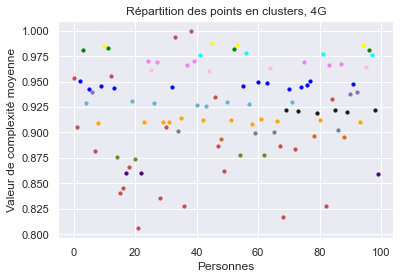

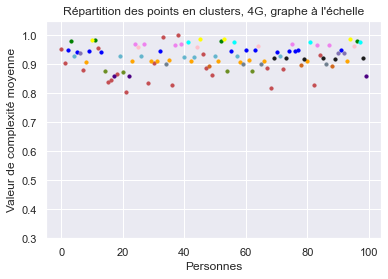

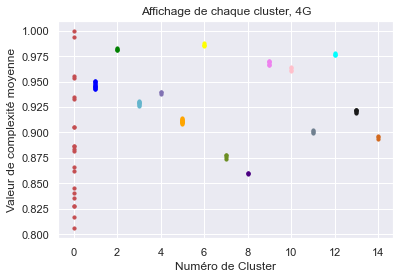

In [20]:
dbscan_4 = modele_dbscan(4, True)


Méthode DBSCAN - Complexités 8G

Nombre de clusters déterminés : 9

Pourcentage cluster -1 : 12 %
Pourcentage cluster 0 : 41 %
Pourcentage cluster 1 : 27 %
Pourcentage cluster 2 : 3 %
Pourcentage cluster 3 : 4 %
Pourcentage cluster 4 : 3 %
Pourcentage cluster 5 : 3 %
Pourcentage cluster 6 : 4 %
Pourcentage cluster 7 : 3 %


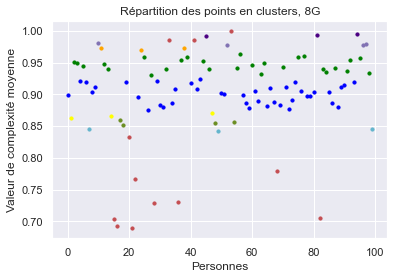

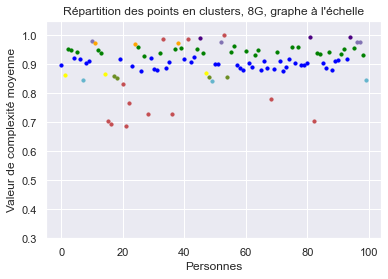

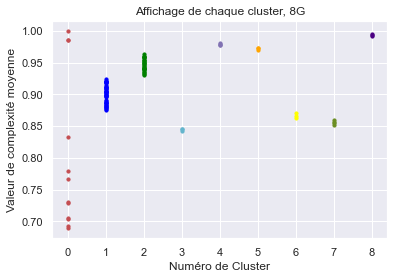

In [21]:
dbscan_8 = modele_dbscan(8, True)


Méthode DBSCAN - Complexités 24G

Nombre de clusters déterminés : 7

Pourcentage cluster -1 : 8 %
Pourcentage cluster 0 : 15 %
Pourcentage cluster 1 : 54 %
Pourcentage cluster 2 : 3 %
Pourcentage cluster 3 : 14 %
Pourcentage cluster 4 : 3 %
Pourcentage cluster 5 : 3 %


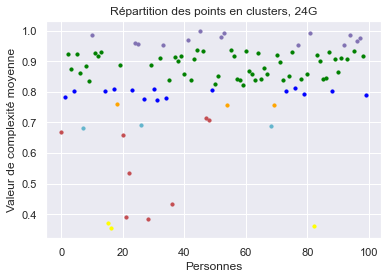

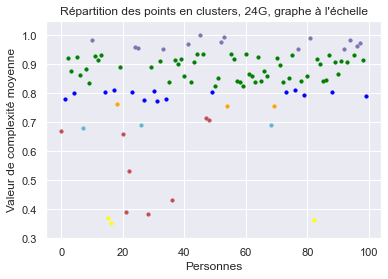

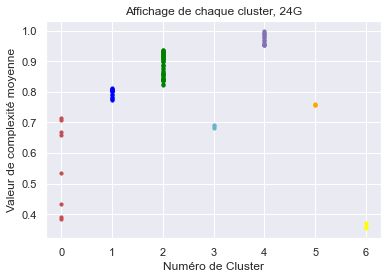

In [22]:
dbscan_24 = modele_dbscan(24, True)

Le modèle DBSCAN ne donne pas les résultats qu'on veut et ne traite pas les données comme nous souhaitons qu'elles le soient. DBSCAN analyse les datas et crée plus de 3 clusters. De plus, ce modèle ne parvient pas à classer toutes les complexités moyennes dans un cluster, il existe toujours un certain nombre de données que le modèle ne parvient pas à classer. 

### Méthode de clustering : Regroupement hiérarchique

In [23]:
from scipy.cluster.hierarchy import dendrogram
def create_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    
    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = create_linkage_matrix(model)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [24]:
# trouver les représentants de chaque cluster créé par le modèle hiérarchique

from scipy.cluster.hierarchy import leaders
from scipy.cluster.hierarchy import fcluster

# fonctions pour trouver les représentants des clusters du modèle hiérarchique
def chercher_ligne(i, link, taille, id1, id2):
    if id1 < taille:
        return i, id1
    if id2 < taille:
        return i, id2
    i1, center1 = chercher_ligne(i+1, link, taille, int(link[id1-taille][0]), int(link[id1-taille][1]))
    i2, center2 = chercher_ligne(i+1, link, taille, int(link[id2-taille][0]), int(link[id2-taille][1]))
    if i1 < id2:
        return i1, center1
    return i2, center2

def representant_cluster(model, linkage, flat_clusters, L, M, n_cluster):
    taille = len(linkage)+1
    i = 0
    while M[i] != n_cluster+1:
        i+=1
    n_ligne_initiale = L[i]-taille
    id1 = int(linkage[n_ligne_initiale][0])
    id2 = int(linkage[n_ligne_initiale][1])
    i, center = chercher_ligne(0, linkage, taille, id1, id2)
    return int(center)

def representants(model):
    linkage = create_linkage_matrix(model)
    flat_clusters = fcluster(linkage, 3, criterion='maxclust')
    L, M = leaders(linkage, flat_clusters)
    representants_clusters = np.zeros(len(M))
    for i in range(len(M)):
        representants_clusters[i] = representant_cluster(model, linkage, flat_clusters, L, M, i)
    return representants_clusters

In [29]:
from sklearn.cluster import AgglomerativeClustering

def modele_hierarchique(n_complexite, *args):
    if n_complexite == 4:
        X = X_4
        X_original = X_4_original
    elif n_complexite == 8:
        X = X_8
        X_original = X_8_original
    else:
        X = X_24
        X_original = X_24_original
    
    model = AgglomerativeClustering(n_clusters = 3, linkage = 'ward', compute_distances = True)
    model.fit(X)
    
    cluster_0 = [i for i in range(100) if model.labels_[i] == 0]
    cluster_1 = [i for i in range(100) if model.labels_[i] == 1]
    cluster_2 = [i for i in range(100) if model.labels_[i] == 2]
    clusters = [cluster_0, cluster_1, cluster_2]
    
    representants_clusters = representants(model)
    
    clusters = classer_clusters_par_complexite(X, clusters)
    representants_clusters = classer_representants_par_complexite(X, representants_clusters)
    
    pourcentages = [len(clusters[i])/100 for i in range(len(clusters))]
    print("Pourcentage cluster de complexité faible:", pourcentages[0]*100, "%")
    print("Pourcentage cluster de complexité moyenne:", pourcentages[1]*100, "%")
    print("Pourcentage cluster de complexité forte:", pourcentages[2]*100, "%", "\n")
    
    inertie_inter = inertie_inter_classe(X_original, clusters, representants_clusters)[0]
    print("Inertie inter:", round(inertie_inter, 2))
    inertie_intra = inertie_intra_classe(X_original, representants_clusters)[0]
    print("Inertie intra:", round(inertie_intra, 2), "\n")
    
    correspondance_representants_moyenne_cluster(X, clusters, representants_clusters)
    
    print("-----------------------------------------------------------------------------------")

    plot_dendrogram(model, truncate_mode="level", p=3) # on affiche les 3 premiers niveaux
    plt.title("Dendrogramme - " + str(n_complexite) + " Gaussiennes\n")
    plt.show()
        
    #afficher les données en points pour montrer les clusters
    plt.scatter(clusters[0], X[clusters[0]], c='red', s=10, cmap='viridis', label = complexite_cluster(0)) 
    plt.scatter(clusters[1], X[clusters[1]], c='green', s=10, cmap='viridis', label = complexite_cluster(1))
    plt.scatter(clusters[2], X[clusters[2]], c='blue', s=10, cmap='viridis', label = complexite_cluster(2))
    plt.legend(loc = 'best')
    plt.ylim(0.3, 1.05) #fixer l'echelle des y
    plt.title('Répartition des points en clusters par Hiérarchique, ' + str(n_complexite) + 'G')
    plt.xlabel('Personnes')
    plt.ylabel('Valeur de complexité moyenne')
    plt.show()

    return model, clusters, pourcentages, representants_clusters, inertie_inter, inertie_intra

Pourcentage cluster de complexité faible: 20.0 %
Pourcentage cluster de complexité moyenne: 35.0 %
Pourcentage cluster de complexité forte: 45.0 % 

Inertie inter: 308.0
Inertie intra: 85.19 

Moyenne du cluster de complexité faible = 0.86
Valeur du représentant du cluster de complexité faible = 0.81
Distance = 0.05 

Moyenne du cluster de complexité moyenne = 0.91
Valeur du représentant du cluster de complexité moyenne = 0.92
Distance = 0.01 

Moyenne du cluster de complexité fort = 0.96
Valeur du représentant du cluster de complexité forte = 0.94
Distance = 0.02 

-----------------------------------------------------------------------------------


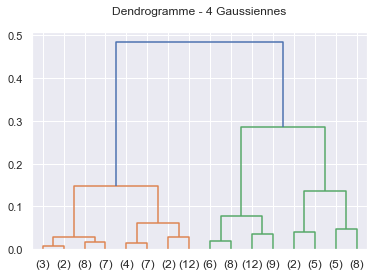

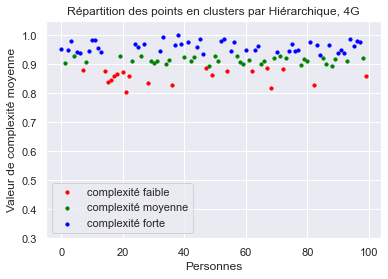

In [31]:
hierarchie_4 = modele_hierarchique(4, True)

Pourcentage cluster de complexité faible: 8.0 %
Pourcentage cluster de complexité moyenne: 52.0 %
Pourcentage cluster de complexité forte: 40.0 % 

Inertie inter: 516.58
Inertie intra: 112.77 

Moyenne du cluster de complexité faible = 0.72
Valeur du représentant du cluster de complexité faible = 0.77
Distance = 0.04 

Moyenne du cluster de complexité moyenne = 0.89
Valeur du représentant du cluster de complexité moyenne = 0.92
Distance = 0.03 

Moyenne du cluster de complexité fort = 0.96
Valeur du représentant du cluster de complexité forte = 1.0
Distance = 0.04 

-----------------------------------------------------------------------------------


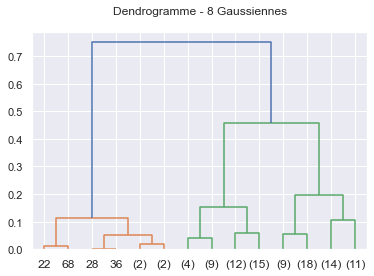

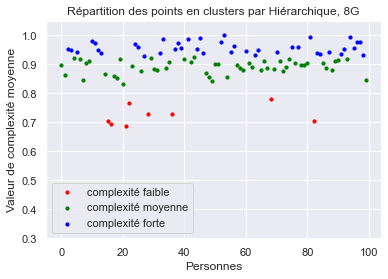

In [32]:
hierarchie_8 = modele_hierarchique(8, True)

Pourcentage cluster de complexité faible: 7.000000000000001 %
Pourcentage cluster de complexité moyenne: 52.0 %
Pourcentage cluster de complexité forte: 41.0 % 

Inertie inter: 1764.47
Inertie intra: 560.16 

Moyenne du cluster de complexité faible = 0.4
Valeur du représentant du cluster de complexité faible = 0.53
Distance = 0.13 

Moyenne du cluster de complexité moyenne = 0.81
Valeur du représentant du cluster de complexité moyenne = 0.72
Distance = 0.09 

Moyenne du cluster de complexité fort = 0.94
Valeur du représentant du cluster de complexité forte = 0.97
Distance = 0.03 

-----------------------------------------------------------------------------------


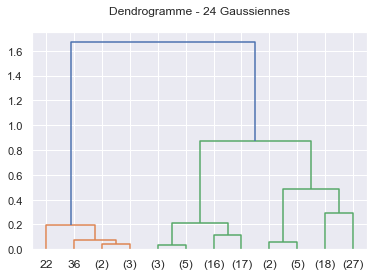

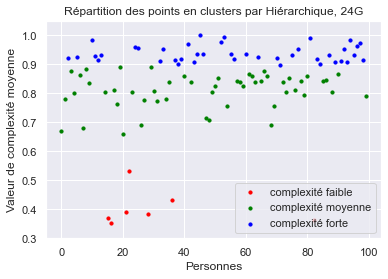

In [33]:
hierarchie_24 = modele_hierarchique(24, True)

### 2e Méthode de clustering : K-Medoids
##### L'avantage de K-Medoids au lieu de K-Means est qu'on peut choisir les centroides des clusters comme représentants de ces derniers

In [38]:
from sklearn.cluster import KMeans
def modele_kmedoids(n_complexite, *args):
    if n_complexite == 4:
        X = X_4
        X_original = X_4_original
    elif n_complexite == 8:
        X = X_8
        X_original = X_8_original
    else:
        X = X_24
        X_original = X_24_original
        
    model = KMedoids(n_clusters = 3)
    model.fit(X)
    
    cluster_0 = [i for i in range(100) if model.labels_[i] == 0]
    cluster_1 = [i for i in range(100) if model.labels_[i] == 1]
    cluster_2 = [i for i in range(100) if model.labels_[i] == 2]
    clusters = [cluster_0, cluster_1, cluster_2]
    
    representants_clusters = model.medoid_indices_
    
    clusters = classer_clusters_par_complexite(X, clusters)
    representants_clusters = classer_representants_par_complexite(X, representants_clusters)
    
    pourcentages = [len(clusters[i])/100 for i in range(len(clusters))]
    print("Pourcentage cluster de complexité faible:", pourcentages[0]*100, "%")
    print("Pourcentage cluster de complexité moyenne:", pourcentages[1]*100, "%")
    print("Pourcentage cluster de complexité forte:", pourcentages[2]*100, "%", "\n")
        
    inertie_inter = inertie_inter_classe(X_original, clusters, representants_clusters)[0]
    print("Inertie inter:", round(inertie_inter, 2))
    inertie_intra = inertie_intra_classe(X_original, representants_clusters)[0]
    print("Inertie intra:", round(inertie_intra, 2), "\n")
    
    correspondance_representants_moyenne_cluster(X, clusters, representants_clusters)
    
    print("-----------------------------------------------------------------------------------------------------------------")
        
    #afficher les données en points pour montrer les clusters
    plt.scatter(clusters[0], X[clusters[0]], c='red', s=10, cmap='viridis', label = complexite_cluster(0)) 
    plt.scatter(clusters[1], X[clusters[1]], c='green', s=10, cmap='viridis', label = complexite_cluster(1))
    plt.scatter(clusters[2], X[clusters[2]], c='blue', s=10, cmap='viridis', label = complexite_cluster(2))
    plt.legend(loc = 'best')
    plt.title('Répartition des points en clusters par K-Medoids, ' + str(n_complexite) + 'G')
    plt.xlabel('Personnes')
    plt.ylabel('Valeur de complexité moyenne')
    plt.ylim(0.3, 1.05) #fixer l'echelle des y
    plt.show()

    return model, clusters, pourcentages, representants_clusters, inertie_inter, inertie_intra

Pourcentage cluster de complexité faible: 20.0 %
Pourcentage cluster de complexité moyenne: 44.0 %
Pourcentage cluster de complexité forte: 36.0 % 

Inertie inter: 157.41
Inertie intra: 31.19 

Moyenne du cluster de complexité faible = 0.86
Valeur du représentant du cluster de complexité faible = 0.86
Distance = 0.0 

Moyenne du cluster de complexité moyenne = 0.92
Valeur du représentant du cluster de complexité moyenne = 0.92
Distance = 0.0 

Moyenne du cluster de complexité fort = 0.97
Valeur du représentant du cluster de complexité forte = 0.97
Distance = 0.0 

-----------------------------------------------------------------------------------------------------------------


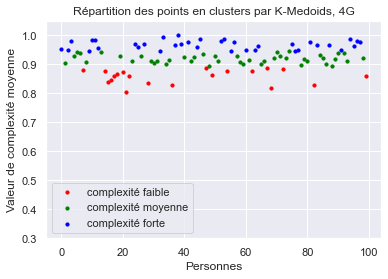

In [39]:
kmedoids_4 = modele_kmedoids(4, True)

Pourcentage cluster de complexité faible: 19.0 %
Pourcentage cluster de complexité moyenne: 41.0 %
Pourcentage cluster de complexité forte: 40.0 % 

Inertie inter: 169.24
Inertie intra: 142.41 

Moyenne du cluster de complexité faible = 0.8
Valeur du représentant du cluster de complexité faible = 0.84
Distance = 0.04 

Moyenne du cluster de complexité moyenne = 0.9
Valeur du représentant du cluster de complexité moyenne = 0.9
Distance = 0.0 

Moyenne du cluster de complexité fort = 0.96
Valeur du représentant du cluster de complexité forte = 0.95
Distance = 0.0 

-----------------------------------------------------------------------------------------------------------------


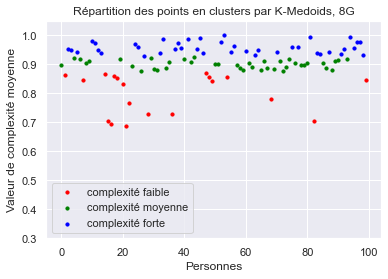

In [40]:
kmedoids_8 = modele_kmedoids(8, True)

Pourcentage cluster de complexité faible: 7.000000000000001 %
Pourcentage cluster de complexité moyenne: 47.0 %
Pourcentage cluster de complexité forte: 46.0 % 

Inertie inter: 1535.39
Inertie intra: 189.75 

Moyenne du cluster de complexité faible = 0.4
Valeur du représentant du cluster de complexité faible = 0.38
Distance = 0.02 

Moyenne du cluster de complexité moyenne = 0.8
Valeur du représentant du cluster de complexité moyenne = 0.81
Distance = 0.01 

Moyenne du cluster de complexité fort = 0.93
Valeur du représentant du cluster de complexité forte = 0.93
Distance = 0.01 

-----------------------------------------------------------------------------------------------------------------


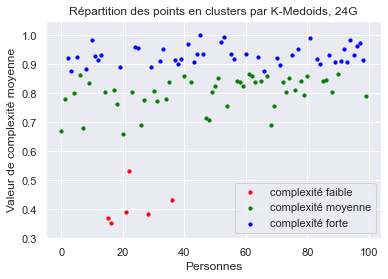

In [41]:
kmedoids_24 = modele_kmedoids(24, True)

## 2e partie : Classification non-supervisées des signatures (writer-independent)

In [42]:
X = []
for i in range(100):
    X = X + extraire_complexite(i+1, 24)
X_2500 = np.reshape(X, (-1, 1)) 

In [43]:
def dans_liste(x, liste):
    i = 0
    while i < len(liste) and liste[i] != x:
        i+=1
    if i == len(liste):
        return False
    return True      

def cluster_correspondance(n_cluster, clusters_f):
    # il n'y a pas de doublons dans les complexités 24G
    #clusters est classe par ordre de complexite, pas les cluster_0, cluster_1, cluster_2
    if n_cluster == 0:
        for i in range(3):
            if dans_liste(cluster_0[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 1:
        for i in range(3):
            if dans_liste(cluster_1[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 2:
        for i in range(3):
            if dans_liste(cluster_2[0], clusters_f[i]):
                return complexite_cluster(i)    

def get_clusters_personne(n_personne):
    return kmedoids_2500.labels_[25*n_personne:25*(n_personne+1)]

def chaque_signature_personne_dans_meme_cluster(n_personne):
    clusters_contenant_signature = get_clusters_personne(n_personne)
    i = 0
    while i < 24 and clusters_contenant_signature[i] == clusters_contenant_signature[i+1]:
        i += 1
    if i == 24:
        return True
    return False

In [44]:
kmedoids_2500 = KMedoids(n_clusters = 3)
#kmedoids_2500 = AgglomerativeClustering(n_clusters = 3, linkage = 'ward', compute_distances = True)
kmedoids_2500.fit(X_2500)

cluster_0 = [i for i in range(2500) if kmedoids_2500.labels_[i] == 0]
cluster_1 = [i for i in range(2500) if kmedoids_2500.labels_[i] == 1]
cluster_2 = [i for i in range(2500) if kmedoids_2500.labels_[i] == 2]
cl = [cluster_0, cluster_1, cluster_2]

clusters = classer_clusters_par_complexite(X_2500, cl)
  
pourcentage_cluster_0 = len(clusters[0])/2500
pourcentage_cluster_1 = len(clusters[1])/2500
pourcentage_cluster_2 = len(clusters[2])/2500
print("Pourcentage cluster de complexité faible:", round(pourcentage_cluster_0, 2)*100, "%")
print("Pourcentage cluster de complexité moyenne:", round(pourcentage_cluster_1, 2)*100, "%")
print("Pourcentage cluster de complexité forte:", round(pourcentage_cluster_2, 2)*100, "%", "\n")

centres_clusters = classer_representants_par_complexite(X_2500, kmedoids_2500.medoid_indices_)

inertie_inter = inertie_inter_classe(X_2500, clusters, centres_clusters)[0]
print("Inertie inter:", round(inertie_inter, 2))
inertie_intra = inertie_intra_classe(X_2500, centres_clusters)[0]
print("Inertie intra:", round(inertie_intra, 2), "\n")

Pourcentage cluster de complexité faible: 8.0 %
Pourcentage cluster de complexité moyenne: 39.0 %
Pourcentage cluster de complexité forte: 54.0 % 

Inertie inter: 35958.53
Inertie intra: 6831.54 



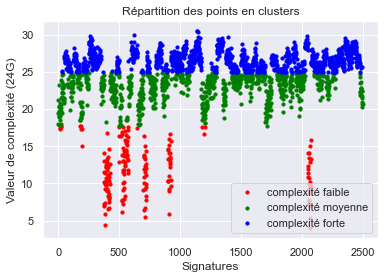

In [45]:
plt.scatter(clusters[0], X_2500[clusters[0]], c='red', s=10, cmap='viridis', label = complexite_cluster(0)) 
plt.scatter(clusters[1], X_2500[clusters[1]], c='green', s=10, cmap='viridis', label = complexite_cluster(1))
plt.scatter(clusters[2], X_2500[clusters[2]], c='blue', s=10, cmap='viridis', label = complexite_cluster(2))
plt.legend(loc = 'best')
plt.title('Répartition des points en clusters')
plt.xlabel('Signatures')
plt.ylabel('Valeur de complexité (24G)')
plt.show()

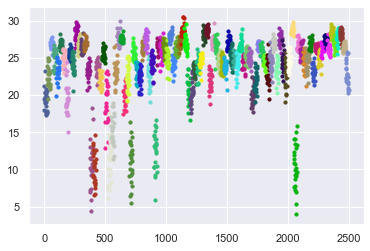

In [46]:
for n_personne in range(100):
    clu_personne = get_clusters_personne(i)
    range_personne = range(2500)[25*n_personne:25*(n_personne+1)]
    couleur_personne = (random.random(), random.random(), random.random())
    plt.scatter(range_personne, 
                X_2500[range_personne], color=couleur_personne, s=10, cmap='viridis', label = complexite_cluster(0)) 
plt.show()

In [47]:
personnes_avec_signatures_mal_classees = []
for i in range(100):
    if not chaque_signature_personne_dans_meme_cluster(i):
        personnes_avec_signatures_mal_classees.append(i)
len(personnes_avec_signatures_mal_classees)

54

### Personnes avec toutes leurs signatures dans le même cluster

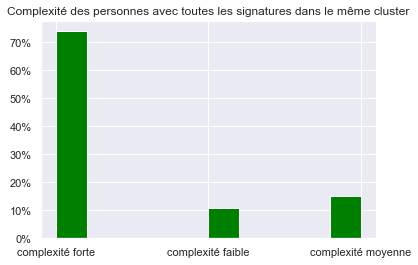

In [48]:
from collections import Counter

clusters_personnes_bien_classees = []
for i in range(100):
    if not dans_liste(i, personnes_avec_signatures_mal_classees):
        clusters_personnes_bien_classees.append(int(get_clusters_personne(i)[0]))

valeurs_histogramme_complexite = [cluster_correspondance(x, clusters) for x in clusters_personnes_bien_classees]

    
plt.hist(valeurs_histogramme_complexite, 
         weights=np.ones(len(valeurs_histogramme_complexite)) / len(valeurs_histogramme_complexite), color = 'green')
plt.title('Complexité des personnes avec toutes les signatures dans le même cluster')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

In [49]:
personnes_bien_classes__dans_meme_cluster_que_methode_moyenne = [0]*100;

for i in range(100):
    if not dans_liste(i, personnes_avec_signatures_mal_classees):
        # complexite du cluster dans lequel cette personne est classee par la methode des 2500 signatures
        complexite_2500 = cluster_correspondance(int(get_clusters_personne(i)[0]), clusters)
        
        # complexite du cluster dans lequel cette personne est classee par la methode des moyennes
        clusters_moyennes = kmedoids_24[1]
        if dans_liste(i, clusters_moyennes[0]):
            complexite_moyennes = complexite_cluster(0)
        elif dans_liste(i, clusters_moyennes[1]):
            complexite_moyennes = complexite_cluster(1)
        else:
            complexite_moyennes = complexite_cluster(2)
        
        personnes_bien_classes__dans_meme_cluster_que_methode_moyenne[i] = (complexite_moyennes == complexite_2500)
    else:
        personnes_bien_classes__dans_meme_cluster_que_methode_moyenne[i] = -1

print("Nombre de personnes dont les signatures sont classées dans le même cluster dans les parties 1 et 2:",
      personnes_bien_classes__dans_meme_cluster_que_methode_moyenne.count(True))
# correspond au nombre de personnes dont toutes les signatures sont classées dans le meme cluster, et ce cluster est 
# est le meme que par la methode k-medoids avec la moyenne des complexités
# par exemple, cela signifie que la personne i a toutes ses signatures classées dans le cluster de forte complexité
# et que cette personne était classée dans le cluster de forte complexité avec la méthode des moyennes des complexités(24G)

# il y en a 46 en toute, ce qui veut dire que toutes les personnes dont toutes les signatures sont dans le meme cluster sont 
# classées comme précédemment. On en conclut donc que ce sont des signatures "aberrantes" pour les autres personnes qui 
# sont classées différemment. Ainsi, si on dispose de suffisamment de signatures de chaque personne pour que la mpyenne soit 
# bien représentative, la technique de la moyenne est plus "robuste" aux outliers.
# Cependant, prendre toutes les 2500 signatures permet de mettre en avant l'aspect "entre deux clusters" de certaines
# personnes, pas ex. si certains ont une proportion non négligeable de signatures classées dans un cluster différent

Nombre de personnes dont les signatures sont classées dans le même cluster dans les parties 1 et 2: 46


### Personnes avec des signatures dans différents clusters

In [50]:
def count_elements(x, tab):
    nb = 0
    for y in tab:
        if x == y:
            nb += 1
    return nb

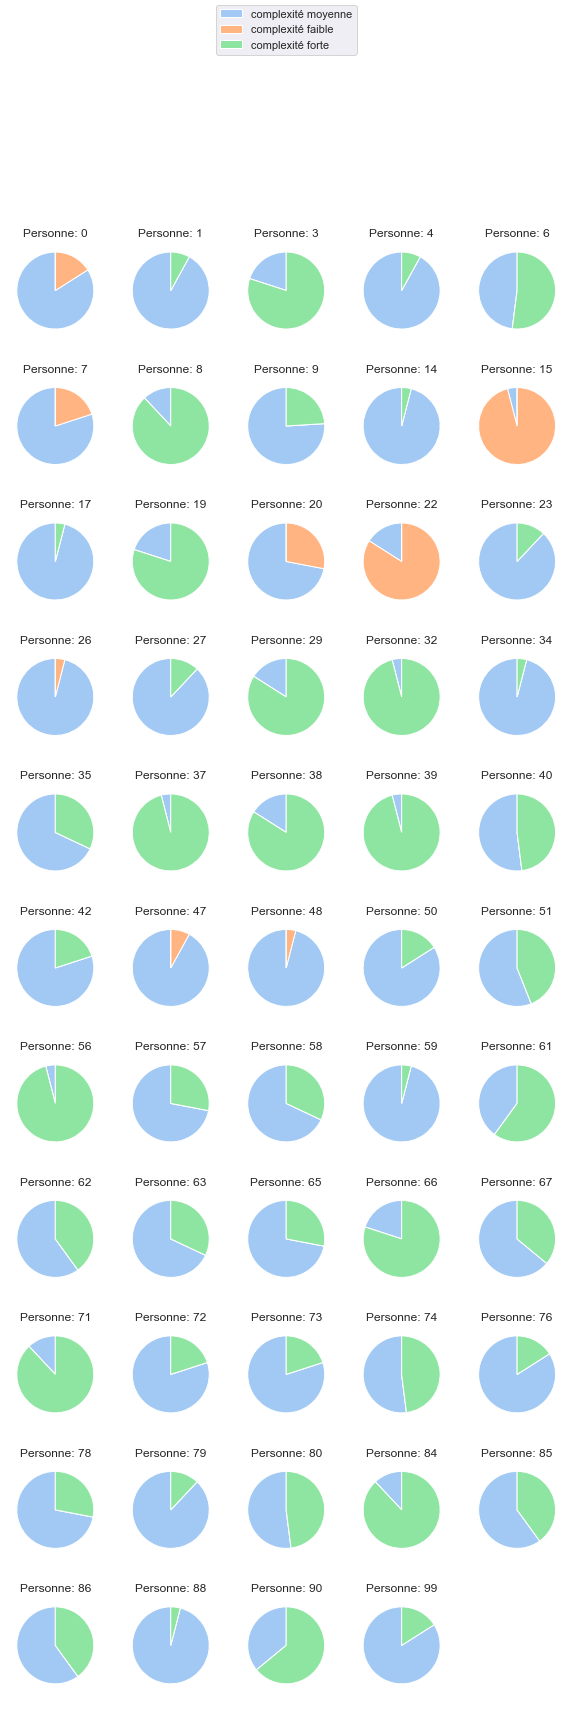

In [51]:
fig, axs = plt.subplots(11, 5, figsize=(10, 27))
axs[-1, -1].axis('off') #ne pas afficher le dernier subplot
for j in range(11):
    for i in range(5):
        if 5*j+i>=len(personnes_avec_signatures_mal_classees):
            x=4
        else:
            personne = personnes_avec_signatures_mal_classees[5*j+i] 
            cluster_personne = get_clusters_personne(personne)

            #define data
            data = [count_elements(i, cluster_personne) for i in range(3)]
            #define cluster labels
            labels = [cluster_correspondance(i, clusters) for i in range(3)]

            #define Seaborn color palette to use
            colors = sns.color_palette('pastel')[0:3]

            #create pie chart
            #axs[i].pie(data, labels = labels, colors = colors, autopct='%.0f%%', startangle = 90)
            patches, texts = axs[j][i].pie(data, colors = colors, startangle = 90)
            axs[j][i].set_title('Personne: '+ str(personne))
fig.legend(patches, labels, loc='upper center')
plt.show()
    

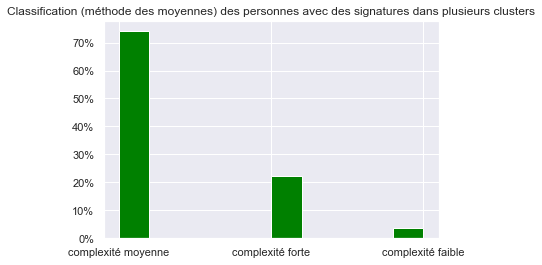

In [52]:
clusters_precedents_des_personnes_mal_classees = [-1]*100;

for i in personnes_avec_signatures_mal_classees:    
    # complexite du cluster dans lequel cette personne est classee par la methode des moyennes
    clusters_moyennes = kmedoids_24[1]
    if dans_liste(i, clusters_moyennes[0]):
        complexite_moyennes = complexite_cluster(0)
    elif dans_liste(i, clusters_moyennes[1]):
        complexite_moyennes = complexite_cluster(1)
    else:
        complexite_moyennes = complexite_cluster(2)
        
    clusters_precedents_des_personnes_mal_classees[i] = complexite_moyennes
    
data = [x for x in clusters_precedents_des_personnes_mal_classees if x != -1]
    
plt.hist(data, weights=np.ones(len(data)) / len(data), color='green')
plt.title('Classification (méthode des moyennes) des personnes avec des signatures dans plusieurs clusters')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

## 3e partie : Apprentissage et généralisation

#### 1ère approche: on divise les signatures de chaque personne en deux parties égales: l'une pour établir les centres, l'autre pour classer

In [53]:
X = []
for i in range(100):
    X = X + extraire_complexite(i+1, 24)
X_2500 = np.reshape(X, (-1, 1)) 

# pour chaque personne, on place la moitie des signatures dans X1 et l'autre dans X2
X1, X2 = [], []
pos_1, pos_2 = [], []
for i in range(100):
    if i % 2 == 0:
        X1 = X1 + extraire_complexite(i+1, 24)[:12]
        pos_1 = pos_1 + list(range(25*i, 25*i+12))
        X2 = X2 + extraire_complexite(i+1, 24)[12:]
        pos_2 = pos_2 + list(range(25*i+12, 25*i+25))
    else:
        X2 = X2 + extraire_complexite(i+1, 24)[:12]
        pos_2 = pos_2 + list(range(25*i, 25*i+12))
        X1 = X1 + extraire_complexite(i+1, 24)[12:]
        pos_1 = pos_1 + list(range(25*i+12, 25*i+25))

X_1250_1 = np.reshape(X1, (-1, 1))
X_1250_2 = np.reshape(X2, (-1, 1))

In [54]:
kmedoids_1250 = KMedoids(n_clusters = 3)
kmedoids_1250.fit(X_1250_1)
representants_ = [kmedoids_1250.labels_[i] for i in range(1250) ] #on fait un tableau [indice_cluster]

In [57]:
def knn(k):
    clusters_p3 = [clusters_majoritaire(X2[i], k) for i in range(1250)]
    cluster_0_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 0]
    cluster_1_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 1]
    cluster_2_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 2]
    cl_p3 = [cluster_0_p3, cluster_1_p3, cluster_2_p3]

    return (inertie_inter_classe(X_2500, cl_p3, [pos_2[x] for x in kmedoids_1250.medoid_indices_])[0])

In [69]:
def optimal_k():
    for k in range (2, 50):
        indice=1
        inertieinter=knn(1)
        newinertie=knn(k)
        if inertieinter>newinertie:
            indice=k
            inertieinter=newinertie

        return indice, inertieinter

opt_k, opt_intertie = optimal_k()
        
print ('k=',opt_k,'est optimal')   
print ("Pour k optimal, inertie inter-classe =", opt_intertie)

k= 1 est optimal
Pour k optimal, inertie inter-classe = 43165.231402127734


In [55]:
def clusters_majoritaire(a,k):
    arr=[]
    for i in range (1250):
        arr.append(np.abs(X_1250_1[i][0]-a))

    arr1 = np.sort(arr) 
 
    #indice=[]
    compteur0=0
    compteur1=0
    compteur2=0
    for j in range(k):
        #indice.append(np.where(arr == arr1[j])[0][0]) #on remplit les indices qui correspondent aux k plus proches voisins
        if representants_[np.where(arr == arr1[j])[0][0]]==0:
            compteur0+=1
        if representants_[np.where(arr == arr1[j])[0][0]]==1:
            compteur1+=1
        if representants_[np.where(arr == arr1[j])[0][0]]==2:
            compteur2+=1
#on choisit de placer la signature de complexité a dans le clusters qui a le plus de plus proches voisins
    repartition=[compteur0,compteur1,compteur2]
    return repartition.index(max(repartition))

In [56]:
#Maintenant il faut discuter de la valeur de k, on peut regarder pour que ce modèle suive au maximum les résultats de la partie deux mais je pense que le plus pertinent est de choisir un k qui minimise l'inertie
#On pourrait aussi décider de minimiser le nombre de signatures d'une même personne placées dans des clusters différents
k, opt_intertie = optimal_k()
clusters_p3 = [clusters_majoritaire(X2[i], k) for i in range(1250)]
cluster_0_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 0]
cluster_1_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 1]
cluster_2_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 2]
cl_p3 = [cluster_0_p3, cluster_1_p3, cluster_2_p3]

inertie_inter = inertie_inter_classe(X_2500, cl_p3, [pos_2[x] for x in kmedoids_1250.medoid_indices_])[0]
print("Inertie inter:", round(inertie_inter, 2))
inertie_intra = inertie_intra_classe(X_1250_2, kmedoids_1250.medoid_indices_)[0]
print("Inertie intra:", round(inertie_intra, 2), "\n")

clusters_p3 = classer_clusters_par_complexite(X_2500, cl_p3)
  
pourcentage_cluster_0 = len(clusters_p3[0])/1250
pourcentage_cluster_1 = len(clusters_p3[1])/1250
pourcentage_cluster_2 = len(clusters_p3[2])/1250
print("Pourcentage cluster de complexité faible:", round(pourcentage_cluster_0, 2)*100, "%")
print("Pourcentage cluster de complexité moyenne:", round(pourcentage_cluster_1, 2)*100, "%")
print("Pourcentage cluster de complexité forte:", round(pourcentage_cluster_2, 2)*100, "%", "\n")

centres_clusters_p3 = classer_representants_par_complexite(X_2500, [pos_2[x] for x in kmedoids_1250.medoid_indices_])

Inertie inter: 38578.77
Inertie intra: 7941.12 

Pourcentage cluster de complexité faible: 7.000000000000001 %
Pourcentage cluster de complexité moyenne: 39.0 %
Pourcentage cluster de complexité forte: 54.0 % 



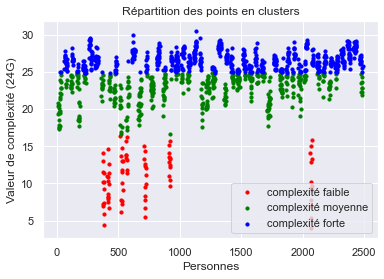

In [59]:
plt.scatter(clusters_p3[0], X_2500[clusters_p3[0]], c='red', s=10, cmap='viridis', label = complexite_cluster(0)) 
plt.scatter(clusters_p3[1], X_2500[clusters_p3[1]], c='green', s=10, cmap='viridis', label = complexite_cluster(1))
plt.scatter(clusters_p3[2], X_2500[clusters_p3[2]], c='blue', s=10, cmap='viridis', label = complexite_cluster(2))
plt.legend(loc = 'best')
plt.title('Répartition des points en clusters')
plt.xlabel('Personnes')
plt.ylabel('Valeur de complexité (24G)')
plt.show()

In [61]:
#on regarde si les signatures classées par cette manière sont dans un cluster différent de leur classification
# dans la partie 2

signatures_classees_differemment = []
clusters_partie_3 = []
clusters_partie_2 = []
for i in range(3):
    for x in clusters_p3[i]:
        if not dans_liste(x, clusters[i]):
            signatures_classees_differemment.append(x)
            clusters_partie_3.append(i)
            if dans_liste(x, clusters[0]):
                clusters_partie_2.append(0)
            elif dans_liste(x, clusters[1]):
                clusters_partie_2.append(1)
            else:
                clusters_partie_2.append(2)
            
print("Nombre de signatures classées différemment entre les parties 2 et 3:", len(signatures_classees_differemment))
print("Signatures classées différemment:", signatures_classees_differemment)

for i in range(len(clusters_partie_3)):
    print("Sig n°", signatures_classees_differemment[i], ", partie 2, dans cluster", clusters_partie_2[i], 
         ", partie 3, dans cluster", clusters_partie_3[i])

Nombre de signatures classées différemment entre les parties 2 et 3: 20
Signatures classées différemment: [16, 18, 20, 24, 182, 520, 522, 532, 571, 574, 917, 1183, 231, 233, 234, 431, 478, 1285, 1476, 1868]
Sig n° 16 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 18 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 20 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 24 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 182 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 520 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 522 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 532 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 571 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 574 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 917 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 1183 , partie 2, dans cluster 0 , partie 3, dans cluster 1
Sig n° 231 , par

In [62]:
def fuction_cluster_personne(personne):
    
    #recupere le cluster dans lequel est presente chaque signature de la personne
    cluster_personne=[]
    
    clusters_p3 = [clusters_majoritaire(X2[i], k) for i in range(1250)]
    cluster_0_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 0]
    cluster_1_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 1]
    cluster_2_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 2]
    cl_p3 = [cluster_0_p3, cluster_1_p3, cluster_2_p3]
    
    num_signatures = range(25*personne, 25*(personne+1))
    for num_signature in num_signatures:
        for j in range(3):
            if dans_liste(num_signature, cl_p3[j]):
                cluster_personne.append(j)
                break
    return cluster_personne

In [63]:
def cluster_correspondance(n_cluster, clusters_f):
    # il n'y a pas de doublons dans les complexités 24G
    #clusters est classe par ordre de complexite, pas les cluster_0, cluster_1, cluster_2
    if n_cluster == 0:
        for i in range(3):
            if dans_liste(cluster_0_p3[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 1:
        for i in range(3):
            if dans_liste(cluster_1_p3[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 2:
        for i in range(3):
            if dans_liste(cluster_2_p3[0], clusters_f[i]):
                return complexite_cluster(i) 

In [54]:
cluster_de_chaque_personne = [fuction_cluster_personne(personne) for personne in range(100)]

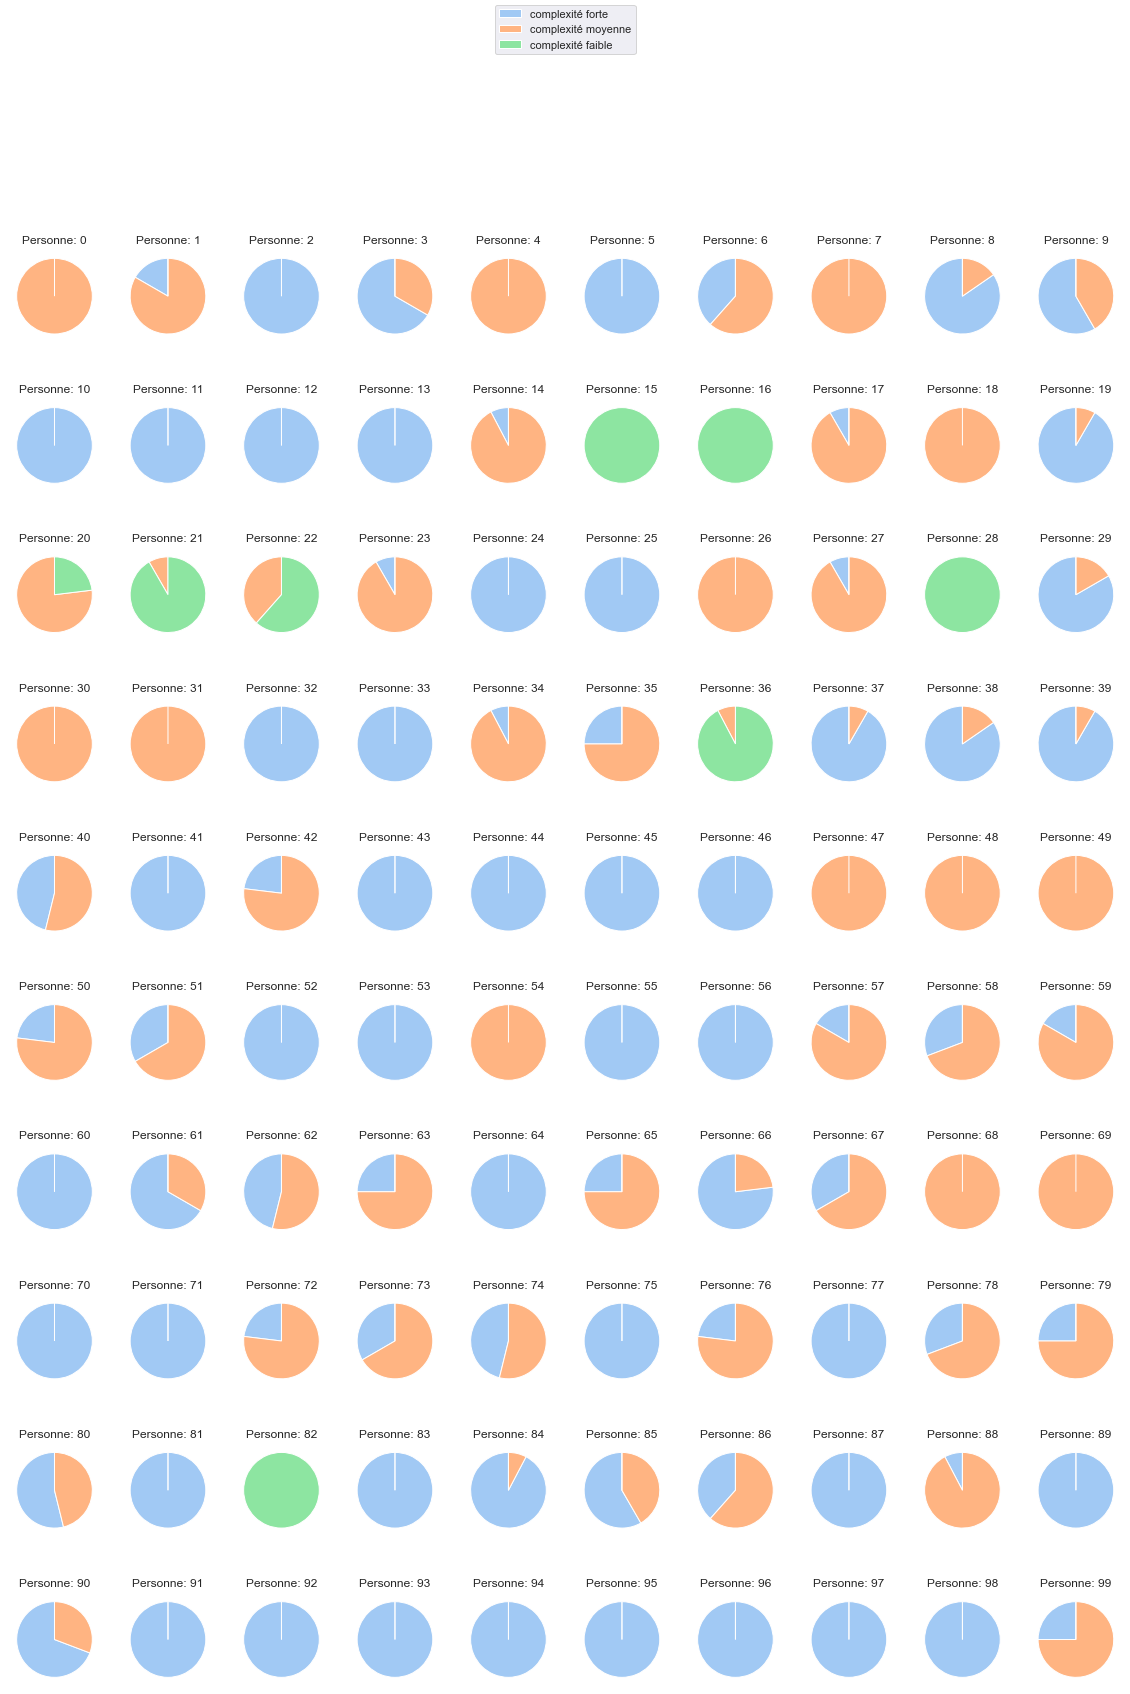

In [55]:
clusters_p3 = [clusters_majoritaire(X2[i], k) for i in range(1250)]
cluster_0_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 0]
cluster_1_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 1]
cluster_2_p3 = [pos_2[i] for i in range(len(clusters_p3)) if clusters_p3[i] == 2]
cl_p3 = [cluster_0_p3, cluster_1_p3, cluster_2_p3]

clusters_p3 = classer_clusters_par_complexite(X_2500, cl_p3) #on classe les clusters par ordre de complexité pour 
                                                             # avoir une bonne légende

nb_ligne = 10
nb_col = 10

fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(20, 27))
for i in range(nb_ligne):
    for j in range(nb_col):
        personne = nb_ligne*i+j
        cluster_personne = cluster_de_chaque_personne[personne]

        #define data
        data = [count_elements(k, cluster_personne) for k in range(3)]
        #define cluster labels
        labels = [cluster_correspondance(k, clusters_p3) for k in range(3)]
        
        #define Seaborn color palette to use
        colors = sns.color_palette('pastel')[0:3]

        #create pie chart
        #axs[i].pie(data, labels = labels, colors = colors, autopct='%.0f%%', startangle = 90)
        patches, texts = axs[i][j].pie(data, colors = colors, startangle = 90)
        axs[i][j].set_title('Personne: '+ str(personne))
        
fig.legend(patches, labels, loc='upper center')
plt.show()

#### 2e approche : on distribue au hasard les 2500 signatures dans X1 ou X2

In [64]:
X = []
for i in range(100):
    X = X + extraire_complexite(i+1, 24)
    
X1_hasard = []
position_1 = []
while len(X1_hasard) != 1250:
    i = random.choice(range(len(X)))
    while dans_liste(i, position_1):
        i = random.choice(range(len(X)))
    position_1.append(i)
    X1_hasard.append(X[i])
    
X2_hasard = []
position_2 = []
while len(X2_hasard) != 1250:
    i = random.choice(range(len(X)))
    while dans_liste(i, position_1) or dans_liste(i, position_2):
        i = random.choice(range(len(X)))
    position_2.append(i)
    X2_hasard.append(X[i])
    
X_1250_hasard_1 = np.reshape(X1_hasard, (-1, 1))
X_1250_hasard_2 = np.reshape(X2_hasard, (-1, 1))

In [65]:
kmedoids_1250_hasard = KMedoids(n_clusters = 3)
kmedoids_1250_hasard.fit(X_1250_hasard_1)

representants_hasard = [kmedoids_1250.labels_[i] for i in range(1250) ] #on fait un tableau [indice_cluster]

In [58]:
def knn(k):
    clusters_h = [clusters_majoritaire(X2_hasard[i], k) for i in range(1250)]
    cluster_0_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 0]
    cluster_1_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 1]
    cluster_2_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 2]
    cl_h = [cluster_0_h, cluster_1_h, cluster_2_h]

    return (inertie_inter_classe(X_2500, cl_h, [pos_2[x] for x in kmedoids_1250_hasard.medoid_indices_])[0])

knn(2)

10456.892780750504

In [67]:
def optimal_k_hazard():
    for k in range (2, 50):
        indice=1
        inertieinter=knn(1)
        newinertie=knn(k)
        if inertieinter>newinertie:
            indice=k
            inertieinter=newinertie
            
    return indice, inertieinter
       

print ('k=', opt_k,'est optimal')   
print ("Pour k optimal, inertie inter-classe =", opt_inertie)

k= 11 est optimal
Pour k optimal, inertie inter-classe = 10422.181428791633


In [66]:
k, opt_inertie = optimal_k_hazard()
clusters_h = [clusters_majoritaire(X2_hasard[i], k) for i in range(1250)]
cluster_0_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 0]
cluster_1_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 1]
cluster_2_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 2]
cl_h = [cluster_0_h, cluster_1_h, cluster_2_h]

inertie_inter = inertie_inter_classe(X_2500, cl_h, [pos_2[x] for x in kmedoids_1250_hasard.medoid_indices_])[0]
print("Inertie inter:", round(inertie_inter, 2))
inertie_intra = inertie_intra_classe(X_1250_2, kmedoids_1250_hasard.medoid_indices_)[0]
print("Inertie intra:", round(inertie_intra, 2), "\n")

cl_h = classer_clusters_par_complexite(X_2500, cl_h)
  
pourcentage_cluster_0h = len(cl_h[0])/1250
pourcentage_cluster_1h = len(cl_h[1])/1250
pourcentage_cluster_2h = len(cl_h[2])/1250
print("Pourcentage cluster de complexité faible:", round(pourcentage_cluster_0h, 2)*100, "%")
print("Pourcentage cluster de complexité moyenne:", round(pourcentage_cluster_1h, 2)*100, "%")
print("Pourcentage cluster de complexité forte:", round(pourcentage_cluster_2h, 2)*100, "%", "\n")

centres_clusters_h = classer_representants_par_complexite(X_2500, [pos_2[x] for x in kmedoids_1250_hasard.medoid_indices_])

Inertie inter: 50250.08
Inertie intra: 6902.46 

Pourcentage cluster de complexité faible: 9.0 %
Pourcentage cluster de complexité moyenne: 38.0 %
Pourcentage cluster de complexité forte: 53.0 % 



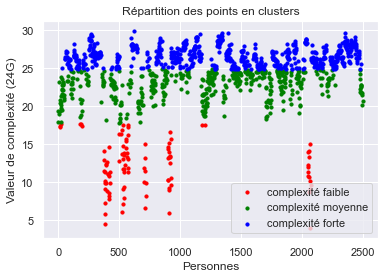

In [61]:
cl_h = classer_clusters_par_complexite(X_2500, cl_h)
plt.scatter(cl_h[0], X_2500[cl_h[0]], c='red', s=10, cmap='viridis', label = complexite_cluster(0)) 
plt.scatter(cl_h[1], X_2500[cl_h[1]], c='green', s=10, cmap='viridis', label = complexite_cluster(1))
plt.scatter(cl_h[2], X_2500[cl_h[2]], c='blue', s=10, cmap='viridis', label = complexite_cluster(2))
plt.legend(loc = 'best')
plt.title('Répartition des points en clusters')
plt.xlabel('Personnes')
plt.ylabel('Valeur de complexité (24G)')
plt.show()

In [67]:
#on regarde si les signatures classées par cette manière sont dans un cluster différent de leur classification
# dans la partie 2

signatures_classees_differemment = []
clusters_partie_3 = []
clusters_partie_2 = []
clusters_h=cl_h
for i in range(3):
    for x in clusters_h[i]:
        if not dans_liste(x, clusters[i]):
            signatures_classees_differemment.append(x)
            clusters_partie_3.append(i)
            if dans_liste(x, clusters[0]):
                clusters_partie_2.append(0)
            elif dans_liste(x, clusters[1]):
                clusters_partie_2.append(1)
            else:
                clusters_partie_2.append(2)
            
print("Nombre de signatures classées différemment entre les parties 2 et 3:", len(signatures_classees_differemment))
print("Signatures classées différemment:", signatures_classees_differemment)

for i in range(len(clusters_partie_3)):
    print("Sig n°", signatures_classees_differemment[i], ", partie 2, dans cluster", clusters_partie_2[i], 
         ", partie 3, dans cluster", clusters_partie_3[i])

Nombre de signatures classées différemment entre les parties 2 et 3: 6
Signatures classées différemment: [1990, 1868, 1476, 493, 1293, 231]
Sig n° 1990 , partie 2, dans cluster 1 , partie 3, dans cluster 2
Sig n° 1868 , partie 2, dans cluster 1 , partie 3, dans cluster 2
Sig n° 1476 , partie 2, dans cluster 1 , partie 3, dans cluster 2
Sig n° 493 , partie 2, dans cluster 1 , partie 3, dans cluster 2
Sig n° 1293 , partie 2, dans cluster 1 , partie 3, dans cluster 2
Sig n° 231 , partie 2, dans cluster 1 , partie 3, dans cluster 2


La méthode de choisir au hasard les signatures pour créer les centres est moins efficace que de prendre la moitié des signatures de chaque personne ; prendre la moitié des signatures de chacun permet de mieux représenter le set des signatures. De plus, les inerties inter et intra de la méthode de distribution par hasard sont bien moins bonnes que celles de la première méthode.

In [63]:
def fuction_cluster_personne_h(personne):
    
    #recupere le cluster dans lequel est presente chaque signature de la personne
    cluster_personne=[]
    
    clusters_h = [clusters_majoritaire(X2_hasard[i], k) for i in range(1250)]
    cluster_0_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 0]
    cluster_1_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 1]
    cluster_2_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 2]
    cl_h = [cluster_0_h, cluster_1_h, cluster_2_h]
    
    num_signatures = range(25*personne, 25*(personne+1))
    for num_signature in num_signatures:
        for j in range(3):
            if dans_liste(num_signature, cl_h[j]):
                cluster_personne.append(j)
                break
    return cluster_personne

In [64]:
cluster_de_chaque_personne_h = [fuction_cluster_personne_h(personne) for personne in range(100)]

In [65]:
def cluster_correspondance_h(n_cluster, clusters_f):
    # il n'y a pas de doublons dans les complexités 24G
    #clusters est classe par ordre de complexite, pas les cluster_0, cluster_1, cluster_2
    if n_cluster == 0:
        for i in range(3):
            if dans_liste(cluster_0_h[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 1:
        for i in range(3):
            if dans_liste(cluster_1_h[0], clusters_f[i]):
                return complexite_cluster(i)
    if n_cluster == 2:
        for i in range(3):
            if dans_liste(cluster_2_h[0], clusters_f[i]):
                return complexite_cluster(i) 

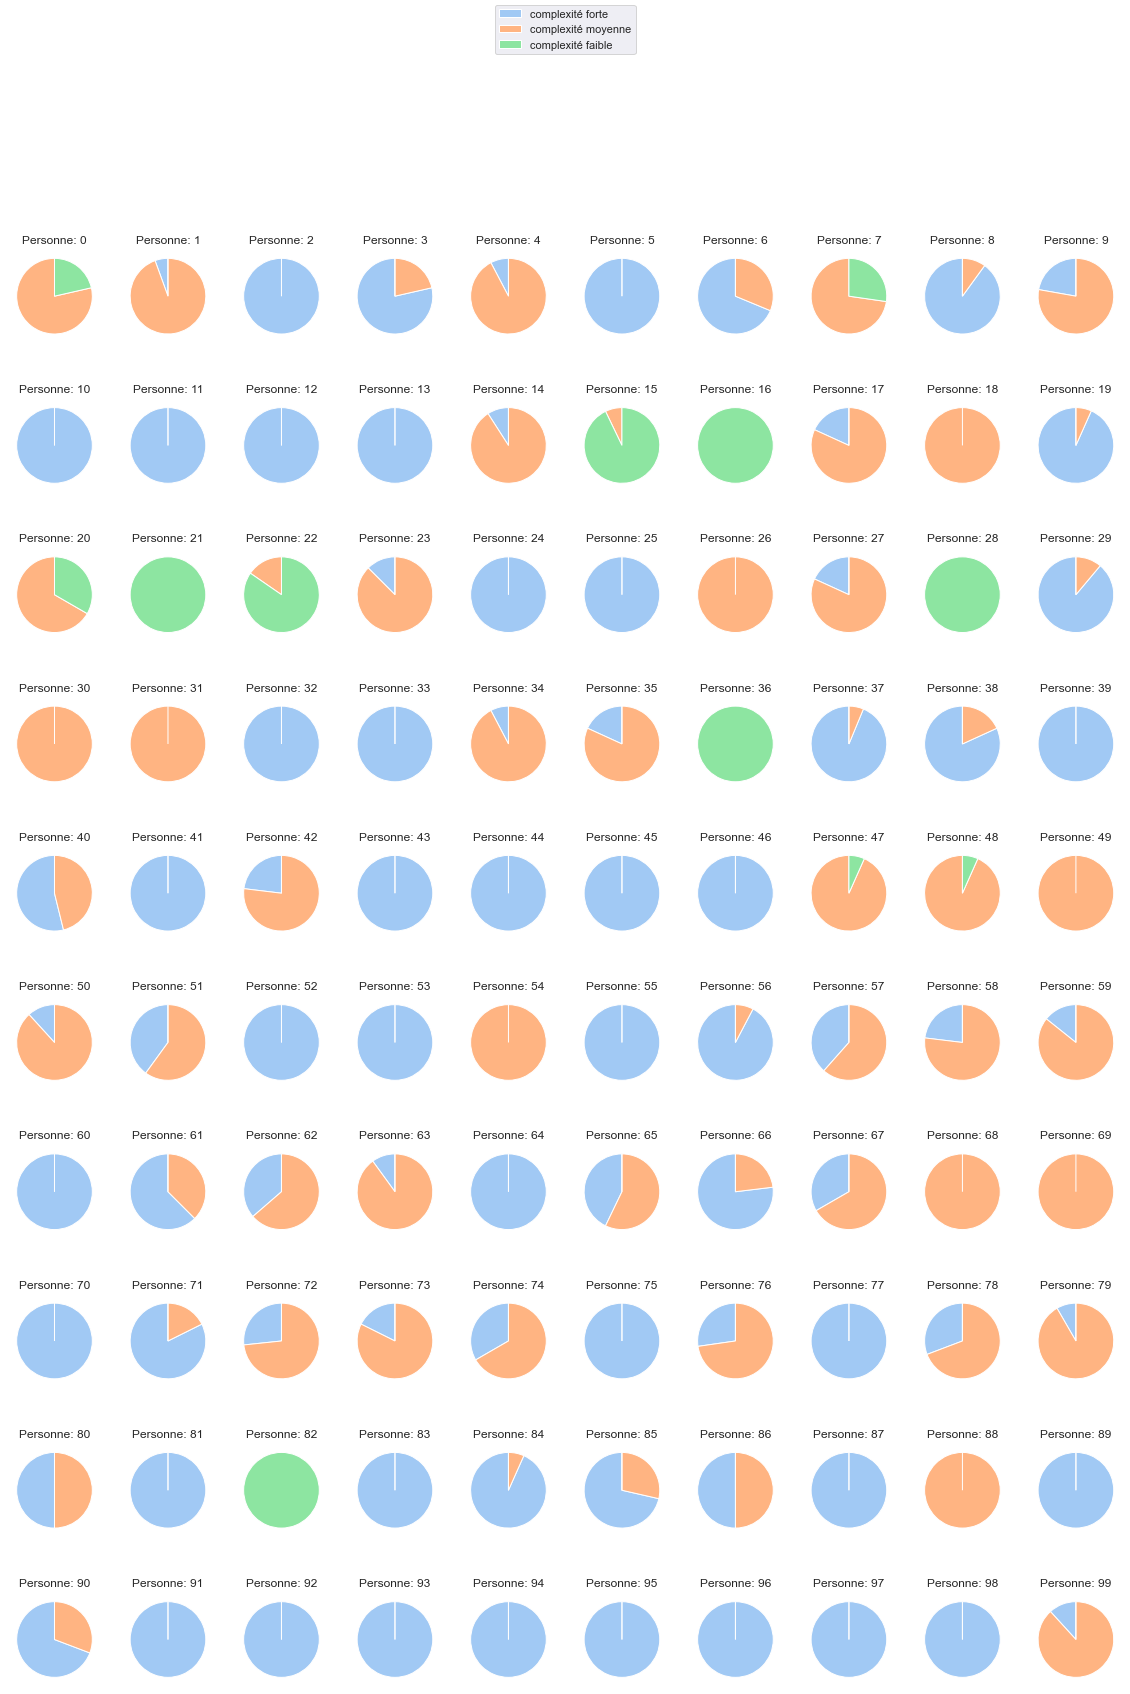

In [66]:
clusters_h = [clusters_majoritaire(X2_hasard[i], k) for i in range(1250)]
cluster_0_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 0]
cluster_1_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 1]
cluster_2_h = [position_2[i] for i in range(len(clusters_h)) if clusters_h[i] == 2]
cl_h = [cluster_0_h, cluster_1_h, cluster_2_h]

clusters_h = classer_clusters_par_complexite(X_2500, cl_h)         #on classe les clusters par ordre de complexité pour 
                                                             # avoir une bonne légende

nb_ligne = 10
nb_col = 10

fig, axs = plt.subplots(nb_ligne, nb_col, figsize=(20, 27))
for i in range(nb_ligne):
    for j in range(nb_col):
        personne = nb_ligne*i+j
        cluster_personne = cluster_de_chaque_personne_h[personne]

        #define data
        data = [count_elements(k, cluster_personne) for k in range(3)]
        #define cluster labels
        labels = [cluster_correspondance_h(k, clusters_h) for k in range(3)]
        
        #define Seaborn color palette to use
        colors = sns.color_palette('pastel')[0:3]

        #create pie chart
        #axs[i].pie(data, labels = labels, colors = colors, autopct='%.0f%%', startangle = 90)
        patches, texts = axs[i][j].pie(data, colors = colors, startangle = 90)
        axs[i][j].set_title('Personne: '+ str(personne))
        
fig.legend(patches, labels, loc='upper center')
plt.show()